# Imports and file loading

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import numpy as np
from event import Event

In [2]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    f.close()
    return i + 1

def open_full_atf_file(file_name):
    file_length=file_len(file_name)
    file_handle=open(directory+file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    data=np.empty((file_length,2))
    i=0
    for row in csv_reader:
        data[i,0]=row[0]
        data[i,1]=row[1]
        i+=1
    
    return data


def open_raw_file(file_name, data_point_start=-1, data_point_end=-1):
    # open full file
    if data_point_start == -1:
        data_point_start=0
    if data_point_end == -1:
        data_point_end=file_len(file_name)
    print data_point_end
    
    data=np.empty((data_point_end-data_point_start,2))
        
    file_handle=open(file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    
    for i in range(0, data_point_start):
        row=csv_reader.next()
    
    for i in range(0, data_point_end-data_point_start):
        row=csv_reader.next()
        try:
            data[i,0]=row[0]
            data[i,1]=row[1]
        except:
            continue
            
    file_handle.close()
    
    return data

# Preliminary

In [3]:
# File info
directory='./data/'
file_name='Chip4_HCT116_0021_0.005'
file_length=file_len(directory+file_name)

In [4]:
# Define search parameters
interval=1000000

baseline_avg_length=200    # was 200
event_avg_length=5
trigger_sigma_threshold=5
max_search_length=1000

event_indices=np.empty((0,2),dtype=int)
baseline=np.empty((0,4), dtype=float)

In [5]:
i=0
start=1000
stop=interval
data=open_raw_file(directory+file_name, 1000, 1000000)

1000000


In [6]:
baseline_avg_length=200    # was 200
event_avg_length=5
trigger_sigma_threshold=5
max_search_length=1000
baseline=np.empty((0,4))

current_index=0
while current_index+baseline_avg_length <= data.shape[0]:
    baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
    baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
    baseline=np.vstack((baseline, [[data[current_index,0], baseline_avg,\
                                    baseline_avg-1.*trigger_sigma_threshold*baseline_sigma,\
                                    baseline_avg+1.*trigger_sigma_threshold*baseline_sigma]]))
    current_index+=baseline_avg_length

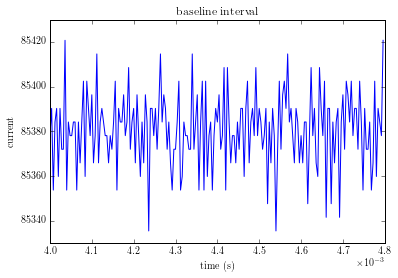

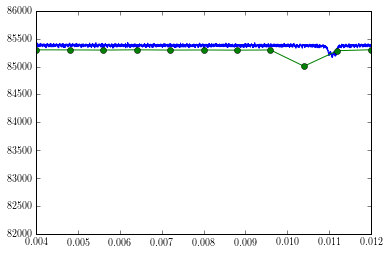

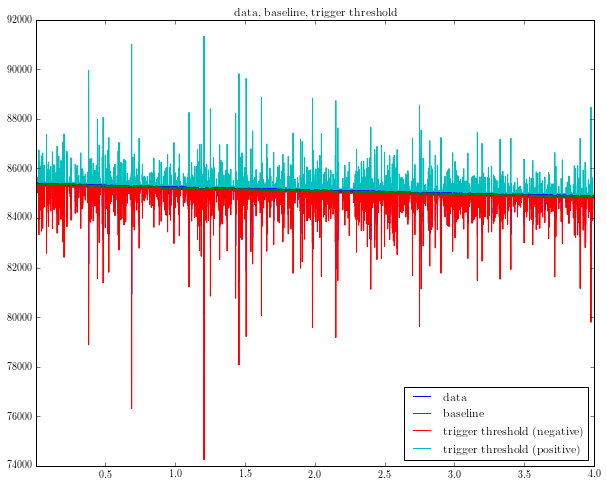

In [ ]:
# Plot current over interval used to calculate the baseline
plt.plot(data[:baseline_avg_length,0], data[:baseline_avg_length,1])

plt.title('baseline interval')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('time (s)')
plt.ylabel('current')

plt.show()

# Plot close up
a=0
b=2000
plt.plot(data[a:b,0], data[a:b,1])
#plt.plot(baseline[a:b,0], baseline[:,1], label='baseline')
plt.plot(baseline[:,0], baseline[:,2], label='trigger threshold (negative)', marker='o')
#plt.plot(baseline[a:b,0], baseline[:,3], label='trigger threshold (positive)')
plt.xlim(data[a,0],data[b,0])
plt.ylim(82000,86000)
plt.show()

# Plot baseline and trigger value
fig=plt.figure(figsize=(10,8))
plt.plot(data[:,0], data[:,1], label='data')
plt.plot(baseline[:,0], baseline[:,1], label='baseline')
plt.plot(baseline[:,0], baseline[:,2], label='trigger threshold (negative)')
plt.plot(baseline[:,0], baseline[:,3], label='trigger threshold (positive)')

plt.xlim(data[0,0], data[-1,0])

plt.legend(loc='lower right')

plt.title('data, baseline, trigger threshold')
plt.show()

# Begin file scan

In [ ]:
baseline=np.empty((0,4), dtype=float)
event_indices=np.empty((0,2),dtype=int)

i=0
file_finished=False
while file_finished == False:
    # Load next interval
    print 'i=',i
    start=1000+i*interval
    stop=start+interval
    if stop+interval > file_length:
        stop=file_length
        file_finished = True
    data=open_raw_file(directory+file_name, start, stop)
    i+=1
    
    
    try:
        current_index=0
        baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
        baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
        trigger_threshold=trigger_sigma_threshold*baseline_sigma
        baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-trigger_threshold,\
                                           baseline_avg+trigger_threshold]], dtype=float)))
        while True:
            # Look for events
            
            
            start_trigger_found = False
            while start_trigger_found == False:
                # Current exceeds trigger threshold
                if abs(data[current_index,1]-baseline_avg) >= trigger_threshold:
                    # Check to see which updated baseline to compare to
                    if event_indices.shape[0]>0:
                        if current_index-2*baseline_avg_length >= event_indices[-1,-1]:
    
                            # Update baseline (i.e. in case of drift)
                            baseline_avg=np.mean(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                            baseline_sigma=np.std(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                            trigger_threshold=trigger_sigma_threshold*baseline_sigma
                            baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                                   baseline_avg+1.*trigger_threshold]], dtype=float)))
                        else: 
                            print 'baseline conflict!'
                    else:
                        # Update baseline (i.e. in case of drift)
                            baseline_avg=np.mean(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                            baseline_sigma=np.std(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                            trigger_threshold=trigger_sigma_threshold*baseline_sigma
                            baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                                baseline_avg+1.*trigger_threshold]], dtype=float)))
                            
                        # Point still exceeds trigger threshold
                    if abs(data[current_index,1]-baseline_avg) >= trigger_threshold: 
                        # Trigger, get first point to exit baseline
                        event_avg=np.mean(data[current_index-event_avg_length:current_index,1])
                        while start_trigger_found == False:
                            if abs(event_avg)>=abs(baseline_avg):
                                print 'event #', event_indices.shape[0]
                                
                                start_index=current_index-event_avg_length/2+1
                                print '\tstart time:', data[start_index,0]
                                start_trigger_found = True
                            else:
                                event_avg=np.mean(data[current_index-event_avg_length:current_index,1])
                                current_index-=1
                    else:
                        print 'cancelled event...'
                current_index+=1
    
    
            # Look for possible event end
            stop_trigger_found = False
            event_avg=np.mean(data[current_index:current_index+event_avg_length,1])
            while stop_trigger_found == False:     
                # Still in event
                if abs(event_avg) <= abs(baseline_avg):
                    current_index+=1
                    event_avg=np.mean(data[current_index:current_index+event_avg_length,1])
    
                # Event end found
                else:
                    stop_trigger_found = True
                    stop_index=current_index+event_avg_length/2
                    current_index=stop_index+5#1
                    event_indices=np.vstack((event_indices, [[start_index, stop_index]]))
    
                # Maximum search length
                if current_index-start_index >= max_search_length:
                    print 'hit maximum search length...\n'
                    print '\tcurrent_index=', current_index, 'start_index=', start_index, '\n'
                    stop_trigger_found = True
                    current_index=start_index+max_search_length #remove max search length
                    baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
                    baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
                    trigger_threshold=trigger_sigma_threshold*baseline_sigma
                    baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                                   baseline_avg+1.*trigger_threshold]], dtype=float)))       

                #print '\tt=', data[event_indices[-1,0],0]
                #print '\t', event_indices[-1,0], event_indices[-1,1], event_indices[-1,1]-event_indices[-1,0]
    except:
        print '??????\n\n??????'
        continue

i= 0
1001000
event # 0
	start time: 0.010788
cancelled event...
event # 1
	start time: 0.023212
event # 2
	start time: 0.02902
baseline conflict!
event # 3
	start time: 0.031196
baseline conflict!
event # 4
	start time: 0.032272
cancelled event...
event # 5
	start time: 0.03988
baseline conflict!
event # 6
	start time: 0.042052
baseline conflict!
event # 7
	start time: 0.04446
baseline conflict!
event # 8
	start time: 0.04584
event # 9
	start time: 0.049408
baseline conflict!
event # 10
	start time: 0.05104
baseline conflict!
event # 11
	start time: 0.052924
event # 12
	start time: 0.060284
cancelled event...
event # 13
	start time: 0.078052
event # 14
	start time: 0.088992
baseline conflict!
event # 15
	start time: 0.090008
hit maximum search length...

	current_index= 22502 start_index= 21502 

event # 15
	start time: 0.097448
event # 16
	start time: 0.104508
event # 17
	start time: 0.108704
cancelled event...
event # 18
	start time: 0.12056
event # 19
	start time: 0.13158
baseline c